# Basic usage

Thunder offers a variety of analyses and workflows for spatial and temporal data. When run on a cluster, most methods are efficiently and automatically parallelized, but Thunder can also be used on a single machine, especially for testing purposes. 

We'll walk through a very simple example here as an introduction. The entry point for most workflows is the ``ThunderContext``. If you type ``thunder`` to start the interactive shell, this context is automatically provided as ``tsc``, which is an object that primarily provides functionality for loading and exporting data.

We'll start by loading and exploring some toy example data:

In [1]:
data = tsc.loadExample('fish-series')

``data`` is a ``Series`` object, which is a generic collection of one-dimensional array data sharing a common index. We can inspect it to see metadata:

In [2]:
data

Series
nrecords: None (inspect to compute)
dtype: float
dims: None (inspect to compute)
index: [  0   1   2   3   4   5   6   7   8   9  10  11 ... ] (length: 240)

A ``Series`` object is a collection of key-value records, each containing an identifier as a key and a one-dimensional array as a value. We can look at the first key and value by using ``first()``.

In [3]:
key, value = data.first()

We see that the ``first`` key in this example ``Series`` data is the tuple (0,0,0), corresponding to an x, y, z coordinate of an original movie.

In [4]:
key

(0, 0, 0)

The value in this case is a time series of 240 observations, represented as a 1d numpy array.


In [5]:
value.shape

(240,)

We can extract a random subset of records and plot their time series, after converting to `TimeSeries` (which enables time-specific methods), and applying a simple baseline normalization. Here and elsewhere, we'll use the excellent ``seaborn`` package for styling figures, but this is entirely optional.

In [6]:
%matplotlib inline

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")

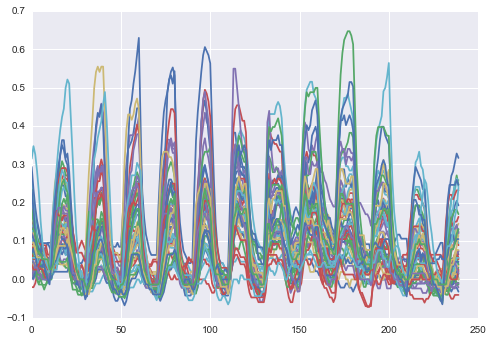

In [8]:
examples = data.toTimeSeries().normalize().subset(50, thresh=0.05)
sns.set_style('darkgrid')
plt.plot(examples.T);

We can also compute a statistic for each record using the method:

In [9]:
means = data.seriesStdev()
means.first()

((0, 0, 0), 0.37996710383926657)

``means`` is now itself a ``Series``, where the value of each record is the mean across time


For this ``Series``, since the keys correspond to spatial coordinates, we can ``pack`` the results back into a local array. ``pack`` is an operation that converts ``Series`` data, with spatial coordinates as keys, into an n-dimensional numpy array. In this case, the result is 3D, reflecting the original input data.

In [10]:
img = means.pack()
img.shape

(76, 87, 2)

``pack`` is an example of a local operation, meaning that all the data involved will be sent to the Spark driver node. For larger data sets, this can be very problematic - it's a good idea to downsample, subselect, or otherwise reduce the size of your data before attempting to ``pack`` large data sets!

To look at this array as an image, we'll use `matplotlib` via a helper function included with Thunder.

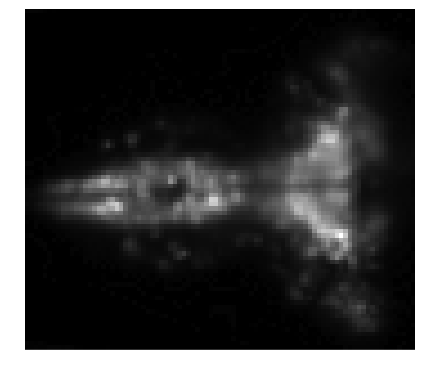

In [11]:
from thunder import Colorize
image = Colorize.image
image(img[:,:,0])

It's also easy to export the result to a ``numpy`` or ``MAT`` file.

```
tsc.export(img, "directory", "npy")
tsc.export(img, "directory", "mat")
```

This will put a ``npy`` file or ``MAT`` file called ``meanval`` in the folder ``directory`` in your current directory. You can also export to a location of Amazon S3 or Google Storage if path is specified with an `s3n://`or `gs://` prefix.

Thunder includes several other toy data sets, to see the available ones:

In [12]:
tsc.loadExample()

['fish-images',
 'fish-series',
 'iris',
 'mouse-images',
 'mouse-params',
 'mouse-series']

Some of them are `Series`, some are `Images`, and some are associated `Params` (e.g. covariates). Let's load an `Images` dataset:

In [13]:
images = tsc.loadExample('mouse-images')

In [14]:
images

Images
nrecords: 500
dtype: int16
dims: min=(0, 0), max=(63, 63), count=(64, 64)

Now every record is an key-value pair where the key is an identifier, and the value is an image

In [15]:
key, value = images.first()

The key is an integer

In [16]:
key

0

And the value is a two-dimensional array

In [17]:
value.shape

(64, 64)

Although `images` is not an array, some syntactic sugar supports easy indexing:

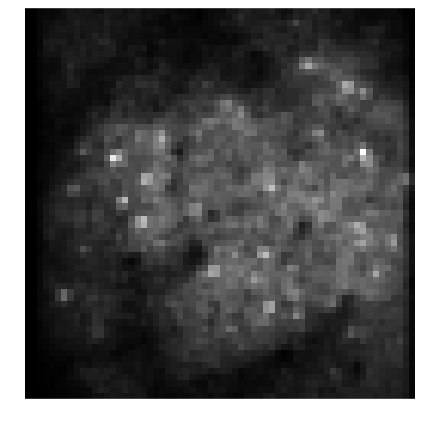

In [18]:
im = images[0]
image(im)

And we can now apply simple parallelized image processing routines

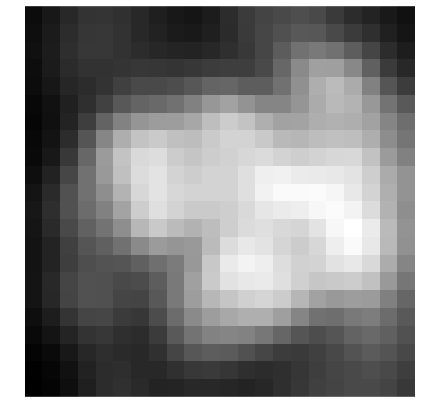

In [19]:
im = images.gaussianFilter(3).subsample(3)[0]
image(im)

For both `Images` and `Series` data, there are a variety of more complex analyses that can be run on these objects, including massively parallel regression, factorization, registration, feature extraction, and more! See the other tutorials for more information.